Groupe:

1 - Onorato, Claudia, 1845448

2 - Harvey, William, 1851388

L'objectif de ce laboratoire est de se familiariser avec les notions de segmentation et de manipulation d'images couleurs. Pour cela, nous allons transformer une photographie réelle afin de lui donner un effet dessin. Deux étapes sont mises en oeuvre: la première est de détecter les contours dans l'image, pour donner un effet trait au feutre noir à notre dessin. La seconde consiste à réduire intelligemment le nombre de couleurs, de telle sorte à obtenir des régions uniformes.


**Remise**: 

La date de remise est fixée au lundi 7 Décembre à 23h55. Une pénalité de 3 points par jour sera appliquée lors d'un retard.

**Documents à remettre** :


Les exercices doivent être codés dans ce fichier TP.ipynb. Les réponses aux questions doivent être inclues dans le code sous forme de commentaires ou dans des cellules dédiées (*Markdown* ou *text*). Les exercices doivent être séparés par des cellules, suivant le template fourni. Vous devez bien identifier chaque exercice et sous-question, et bien commenter le code. Veuillez nommer vos variables de manière explicite et assurez-vous que toutes les figures soient lisibles.

Créer un fichier de rendu **html** (*Fichier -> Télécharger au format... -> HTML*)  de votre code et de vos graphiques. Veuillez remettre tous vos fichiers (.ipynb, html et autres) dans un seul fichier **zip** et nommez ce fichier selon vos matricules (Mat1\_Mat2.zip).


Une pénalité de 3 points sera appliquée si ces consignes ne sont pas respectées.

# Imports et utilitaires

In [1]:
import cv2
import numpy as np
import scipy
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray' # Choix de la color map par défaut, ne pas modifier
import matplotlib
import scipy.signal
matplotlib.rcParams['figure.figsize'] = (25.0, 10.0) # Taille des figures par défaut, peut-être modifié au cas par cas.
from scipy.cluster.vq import kmeans

def imshow(img, title=None, ax=None, is_bgr=False, cmap='gray'):
    """
    param img: image à afficher (soit hxwx3, soit hxw)
    param title: Falcultatif. Titre du graphique
    param ax: Falcultatif. axe sur lequel l'image sera affiché. Si aucun n'est donné, un nouvel axe sera créé.
    param is_bgr: Pour une image couleur, si vraie, effectue la conversion BGR -> RGB
    param cmap: Map de couleur utilisé pour afficher les images.
    """
    show=False
    plt.axis('off')
    if ax is None:
        show=True
        if title is not None:
            plt.title(title)
        ax = plt
    else:
        if title is not None:
            ax.set_title(title)
            ax.set_axis_off()
    
    if img.ndim==2:
        ax.imshow(img, cmap='gray')
    else:
        if is_bgr:
            img = img[:,:,::-1].copy()
        ax.imshow(img)
    if show:
        plt.show()

def f2int(img):
    return (img*255).astype(np.uint8)

def int2f(img):
    return img.astype(np.float32)/255.

# Partie 1
Qui dit dessin dit traits. La première partie de ce TP sera donc consacrée à la détection des contours de l'image, que nous assimilerons par la suite à des traits faits au feutre dans notre dessin. Pour afficher les images, nous vous fournissons une fonction **imshow** (voir la cellule ci-dessus) que vous pouvez utiliser au choix.

## Question 1



Chargez l'image **chat.png**, convertissez-la en valeurs flottantes et affichez-la.



Assurez-vous que les couleurs soient correctement rendues (i.e: telles qu'elles apparaissent dans votre navigateur d'image) et que tous les pixels soient compris dans l'intervalle [0,1].

> **Attention** Si vous utilisez **openCV** (cv2), la librairie ordonne les canaux dans l'ordre <span style="color:blue">b</span>, <span style="color:green">v</span>, <span style="color:red">r</span> au lieu du conventionnel <span style="color:red">r</span>, <span style="color:green">v</span>, <span style="color:blue">b</span>.

> Dans la majeure partie du TP, nous travaillerons avec des valeurs de pixels comprises entre 0 et 1 pour des images de type **np.float32**. Certaines fonctions spécifiques attendent cependant des valeurs comprises entre 0 et 255, pour des images de type np.uint8. Pour vous faciliter le travail, nous fournissons deux fonctions **f2int** et **int2f** qui se chargeront de faire la conversion d'un type vers l'autre (voir cellule de code ci-dessus).


Valeurs de la première ligne de pixel:
 [[[0.3019608  0.42745098 0.59607846]
  [0.3019608  0.42745098 0.59607846]
  [0.3019608  0.42745098 0.5882353 ]
  ...
  [0.7490196  0.74509805 0.7607843 ]
  [0.7490196  0.74509805 0.7607843 ]
  [0.7490196  0.74509805 0.7607843 ]]] 



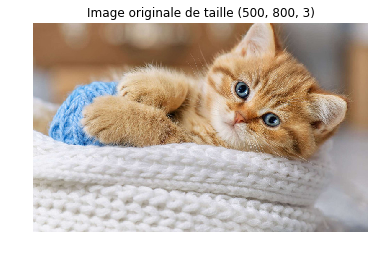

In [2]:
img = cv2.imread('data/chaton.png')
img = int2f(img)

print("Valeurs de la première ligne de pixel:\n", img[0:1,], '\n')
imshow(f2int(img), title=f'Image originale de taille {img.shape}', is_bgr=True)

## Question 2
La clarté d'une image est définie par:
$$
c = \frac{1}{2}(\max(r, v, b) + \min(r, v, b))
$$

Calculez la clarté de l'image et affichez-la.

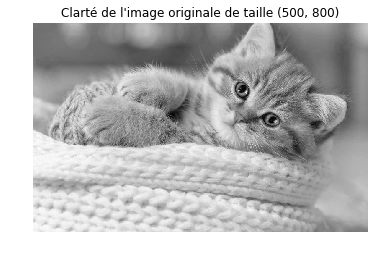

In [3]:
clearness = 0.5 * (np.amax(img, axis=2) + np.amin(img, axis=2))

imshow(f2int(clearness), title=f"Clarté de l'image originale de taille {clearness.shape}")

## Question 3
Dans la suite du TP, nous essayerons de détecter les contours dans l'image. Les différentes méthodes vues en cours ont tendance à être sensibles. Or, dans le cas présent le pelage du chat peut-être assimilé à un bruit poivre et sel dense. Quel type de filtre faut-il utiliser pour l'atténuer? Filtrez la clarté avec ce filtre en utilisant une fenêtre de taille 7. 

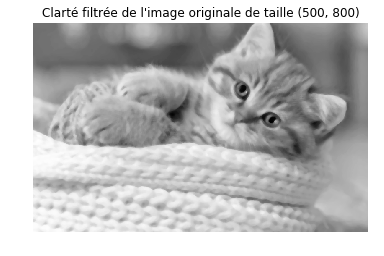

In [4]:
win_size = 7
clearness = int2f(cv2.medianBlur(f2int(clearness), win_size))

imshow(f2int(clearness), title=f"Clarté filtrée de l'image originale de taille {clearness.shape}")


**Important** Pour les prochaines questions, nous allons comparer différentes techniques de détection des contours. Pour cela, nous partirons de l'image de clarté filtrée à la question précédente dans toutes les questions suivantes.

# Question 4

Calculez et affichez sur deux graphiques adjacent (subplots):
- L'image du gradient horizontal
- L'image du gradient vertical

Sur un troisième graphique (nouvelle figure), affichez également la magnitude du gradient.

> Pour calculer les gradients, vous devez définir vous-mêmes les masques de convolution. Pour la convolution en elle-même, utilisez la fonction **scipy.signal.convolve2d**
```python
convolved = scipy.signal.convolve2d(img, mask, mode='same')
```

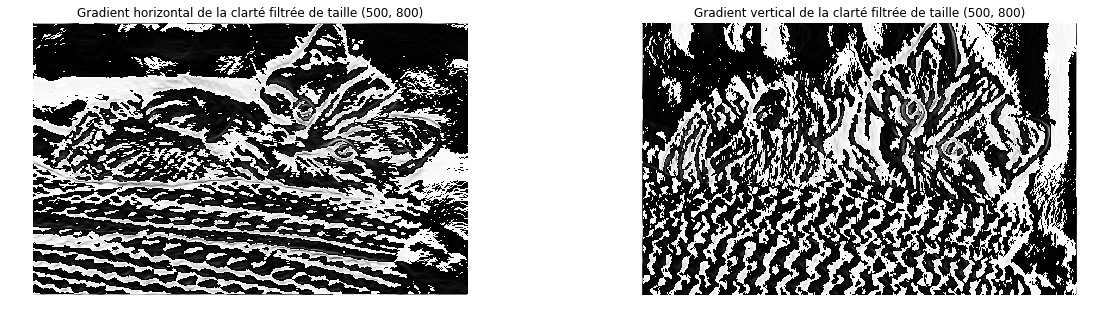

In [5]:
def get_simple_gradients(img, show=True):
    mask_y = np.array([
        [-1,  0,  1],
        [-1,  0,  1],
        [-1,  0,  1],
    ])
    mask_x = np.array([
        [-1, -1, -1],
        [ 0,  0,  0],
        [ 1,  1,  1],
    ])
    if show:
        fig, ax = plt.subplots(ncols=2, figsize=(20, 5))

    gradient_imgs = []

    for idx, items in enumerate([('horizontal', mask_x),('vertical', mask_y)]):
        mask_name, mask = items    
        gradient_imgs.append(scipy.signal.convolve2d(img, mask, mode='same'))
        if show:
            imshow(f2int(gradient_imgs[-1]), title=f"Gradient {mask_name} de la clarté filtrée de taille {gradient_imgs[-1].shape}", ax=ax[idx])
        
    return np.sum(np.array(gradient_imgs)**2,axis=0)


clearness_gradient = get_simple_gradients(clearness);

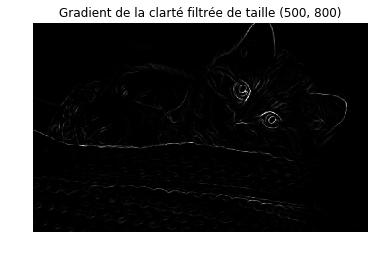

In [6]:
imshow(f2int(clearness_gradient), title=f"Gradient de la clarté filtrée de taille {clearness_gradient.shape}")

# Question 5

Refaites la même expérience, mais cette fois en préfiltrant l'image avec un filtre Gaussien d'écart-type $\sigma=1$. Vous devez construire vous-même le masque Gaussien (vous ne pouvez pas utiliser cv2.GaussianBlur), en justifiant la taille du masque (en fonction de $\sigma$).
Que se passe-t-il lorsqu'on fait varier sigma?

> On rappelle qu'une fonction Gaussienne 2D est donnée par 
$$G(x, y)=A e^{\frac{-(x²+y²)}{2\sigma²}}$$
où $A$ est une constante permettant d'assurer que l'aire sous la gaussienne est bien égale à 1.

**Réponse**: Considérant que le paramètre d'écart-type de notre filtre Gaussien est fixé à 1, on peut alors modifier le nombre de détails à conserver avant d'appliquer le gradient. Donc, plus la taille du filtre gaussien est grand, moins il y aura de détails dans l'image originale.
Dans notre cas, comme nous voulons diminuer le bruit proive et sel, nous allons vouloir prendre une masque de grande taille, afin d'éviter les détails dans l'image avant d'appliquer les filtres gradients.

In [7]:
def get_gaussian_kernel(kernel_size, sigma=1):
    """Kernel_size: tuple of (width, height); sigma: int"""
    assert kernel_size[0] % 2 == 1 and kernel_size[1] % 2 == 1, "size must be odd"
    
    # Python, when doing int division, goes to smallest number in both negative (so -2 if -3//2) and positive (so 1 if 3//2)
    x = np.arange(-kernel_size[0]//2+1, kernel_size[0]//2+1)
    y = np.arange(-kernel_size[1]//2+1, kernel_size[1]//2+1)
    xx, yy = np.meshgrid(x, y)
        
    gaussian_kernel = np.exp(-(xx**2 + yy**2)/(2 * sigma**2))
    gaussian_kernel /=  gaussian_kernel.sum()
        
    return gaussian_kernel

def get_gaussian_filtered(img, kernel_size, sigma=1):
    return scipy.signal.convolve2d(img, get_gaussian_kernel(kernel_size, sigma), mode='same')


In [8]:
matplotlib.rcParams['figure.figsize'] = (5.0, 5.0)


Text(0.5, 1.0, 'Masque de taille 15 par 15 et sigma de 2')

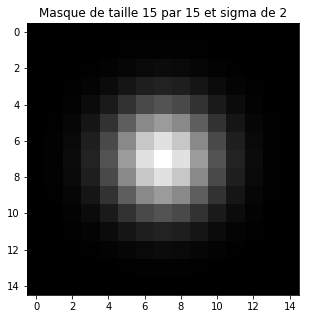

In [9]:
# Exemple de masque
plt.imshow(get_gaussian_kernel((15,15), sigma=2))
plt.title('Masque de taille 15 par 15 et sigma de 2')

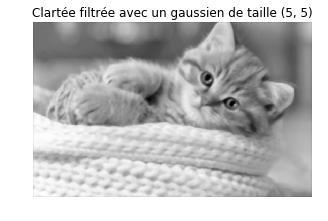

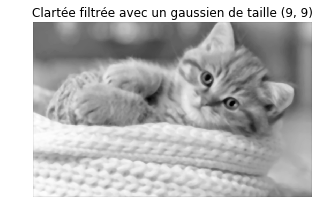

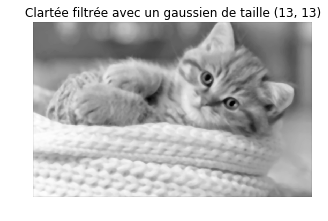

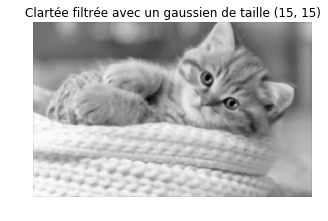

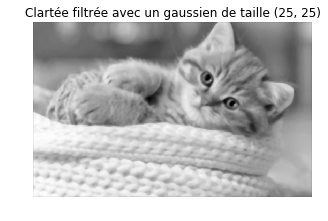

In [10]:
# Exemple du filtrage de l'image sur différents masques
for gaussian_kernel_sizes in [(5,5), (9, 9), (13, 13), (15,15), (25,25)]:
    gauss_clearness_filtered = get_gaussian_filtered(clearness, gaussian_kernel_sizes, 1)
    imshow(f2int(gauss_clearness_filtered), title=f"Clartée filtrée avec un gaussien de taille {gaussian_kernel_sizes}")

Gradient with prealable gaussian filtering with kernel of size (5, 5)
Gradient with prealable gaussian filtering with kernel of size (9, 9)
Gradient with prealable gaussian filtering with kernel of size (13, 13)
Gradient with prealable gaussian filtering with kernel of size (15, 15)
Gradient with prealable gaussian filtering with kernel of size (25, 25)


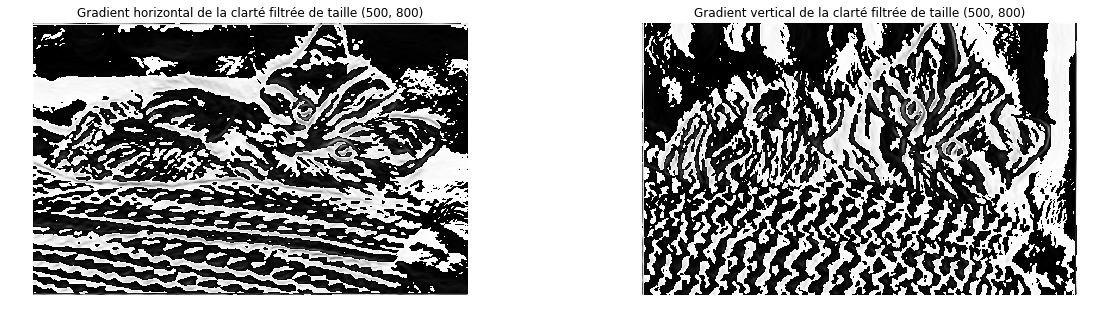

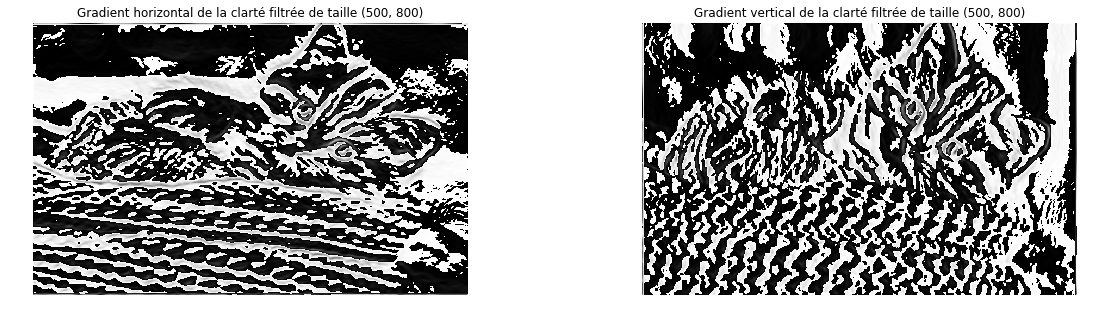

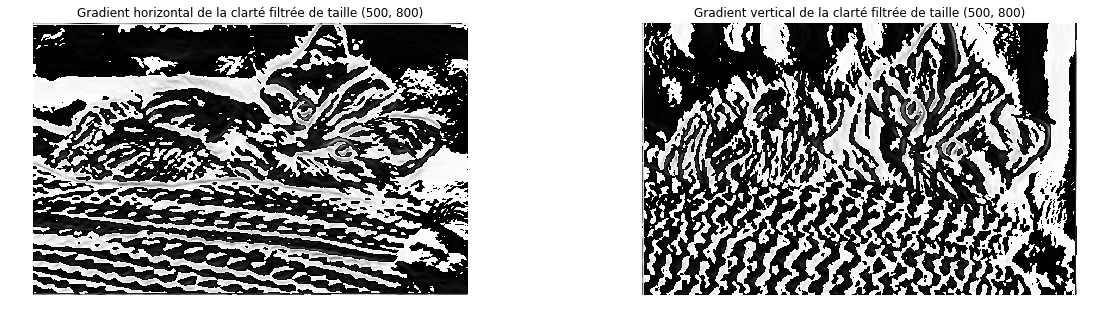

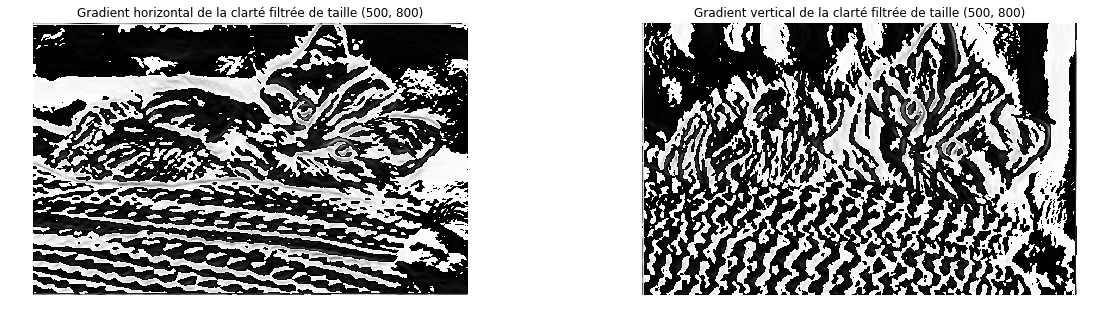

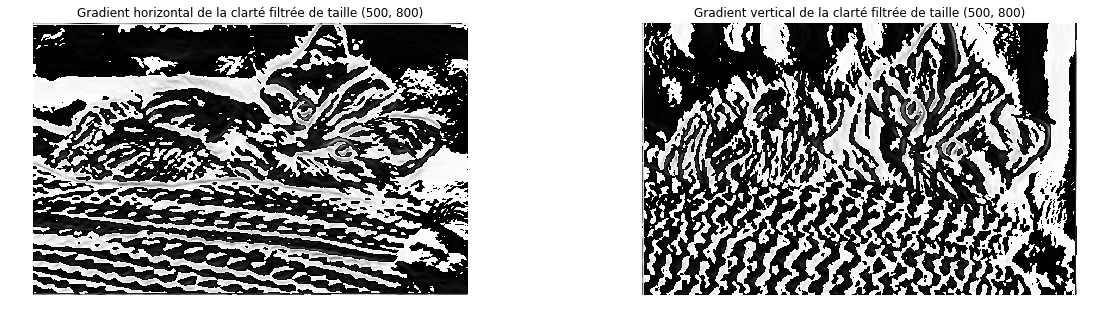

In [11]:
clearness_gradients = []

for gaussian_kernel_sizes in [(5,5), (9, 9), (13, 13), (15,15), (25,25)]:
    gauss_clearness_filtered = get_gaussian_filtered(clearness, gaussian_kernel_sizes, 1)
    print(f"Gradient with prealable gaussian filtering with kernel of size {gaussian_kernel_sizes}")
    clearness_gradients.append((gaussian_kernel_sizes, get_simple_gradients(gauss_clearness_filtered)))

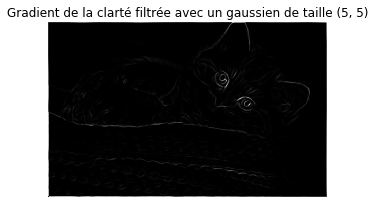

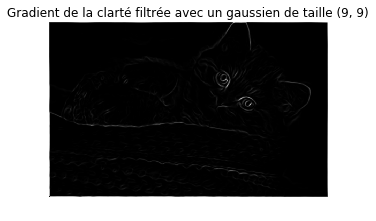

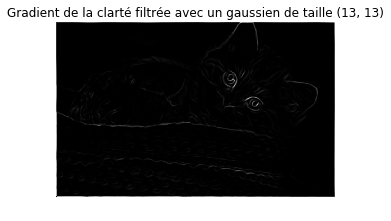

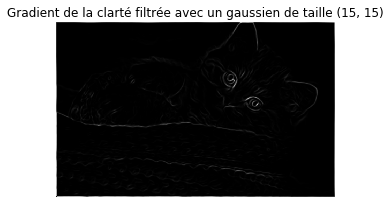

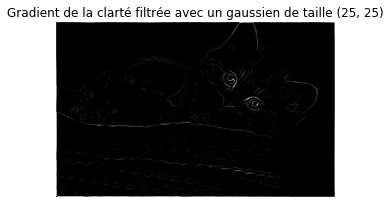

In [12]:
for kernel_size, clearness_gradient in clearness_gradients:
    imshow(f2int(clearness_gradient), title=f"Gradient de la clarté filtrée avec un gaussien de taille {kernel_size}")

In [13]:
gradient_magnitude = clearness_gradients[-2][1]
# gradient_magnitude = get_simple_gradients(get_gaussian_filtered(clearness, (15,15), 2))

**Réponse**: Considérant les résultats ci-dessus, nous allons donc sélectionner un masque de taille 15 par 15, comme il permet de réduire les détails dans l'image, un peu mieux que les autres du moins. Les masques de plus hautes tailles convergeaient vers les mêmes résultats. Comme on peu s'y attendre, c'est en modifiant l'écart type que nous allons davatange réduire le nombre de détails dans l'image originale.

/Users/claudiaonorato/miniconda3/envs/py3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


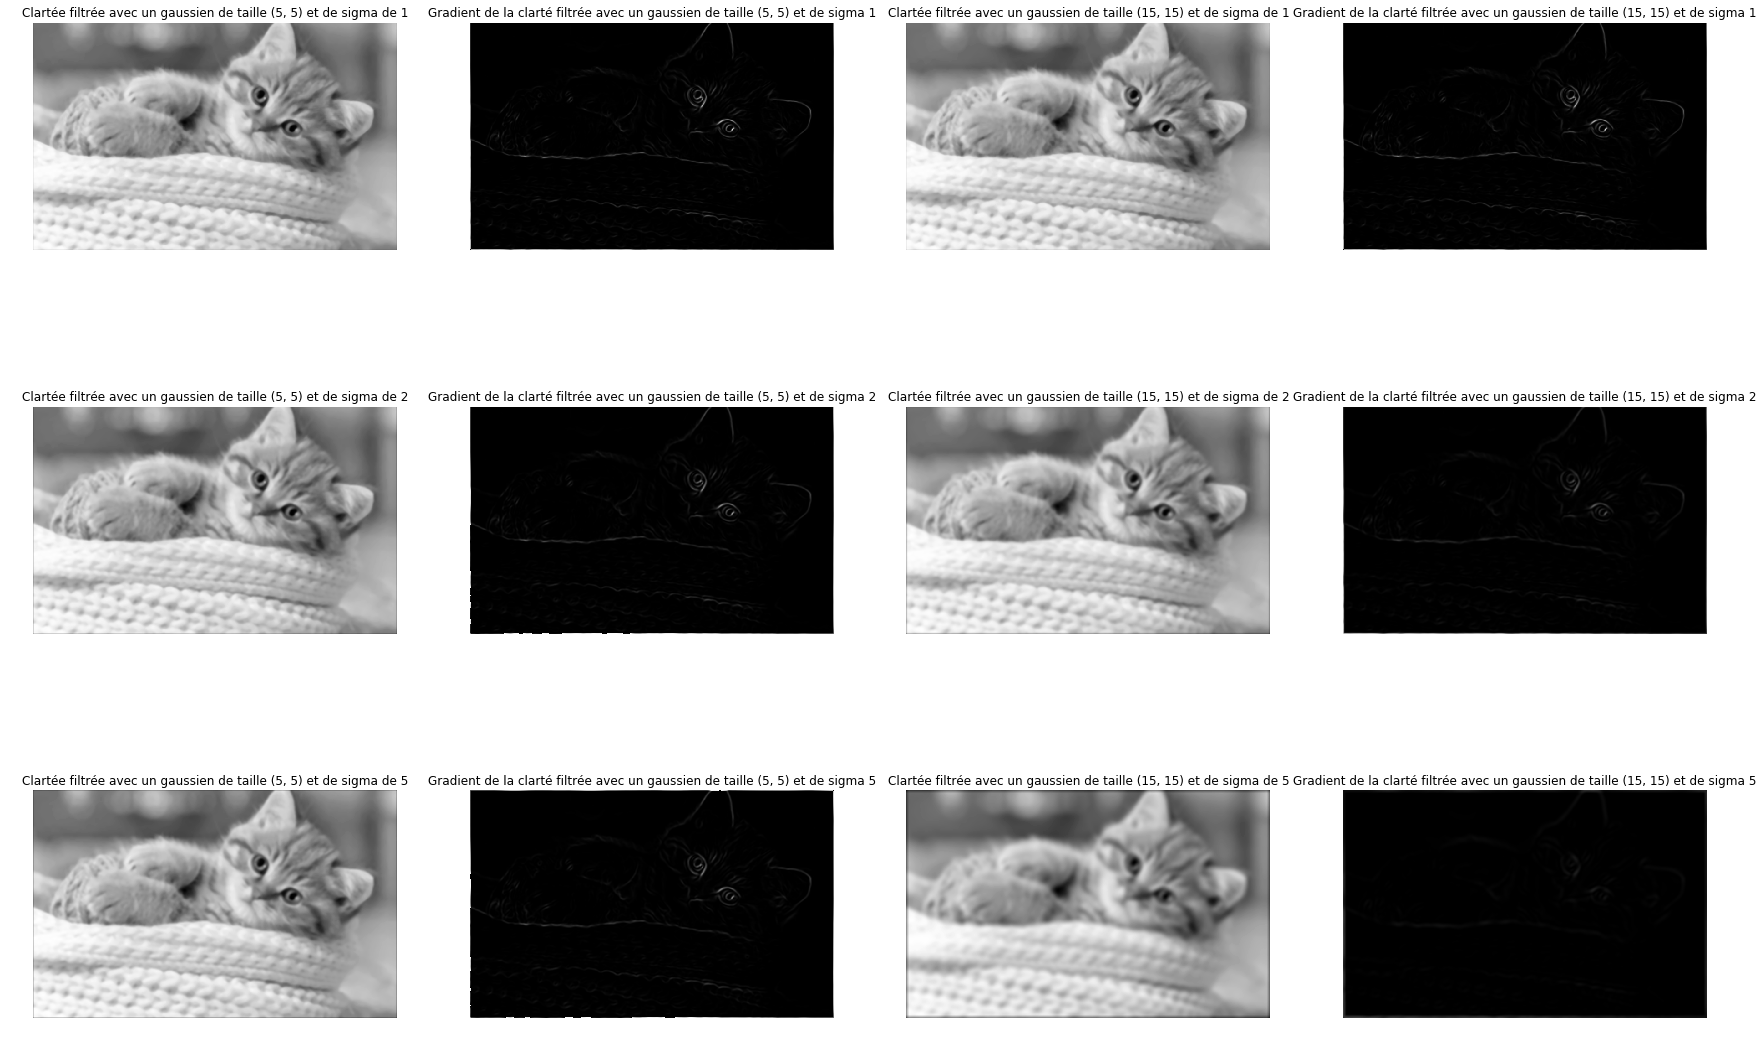

In [14]:
# Exemple du filtrage de l'image sur différents écarts-types
gaussian_size = (15, 15)
gaussian_std_devs = [1, 2, 5]
fig, ax = plt.subplots(ncols=4, nrows=len(gaussian_std_devs), figsize=(30, 20))

for idx, gaussian_std_dev in enumerate(gaussian_std_devs):
    gauss_clearness_filtered = get_gaussian_filtered(clearness, (5, 5), gaussian_std_dev)

    imshow(f2int(gauss_clearness_filtered), title=f"Clartée filtrée avec un gaussien de taille (5, 5) et de sigma de {gaussian_std_dev}", ax=ax[idx][0])
    imshow(
        f2int(get_simple_gradients(gauss_clearness_filtered, show=False)),
        title=f"Gradient de la clarté filtrée avec un gaussien de taille (5, 5) et de sigma {gaussian_std_dev}",
        ax=ax[idx][1]
    )
    
    gauss_clearness_filtered = get_gaussian_filtered(clearness, (15, 15), gaussian_std_dev)

    imshow(f2int(gauss_clearness_filtered), title=f"Clartée filtrée avec un gaussien de taille (15, 15) et de sigma de {gaussian_std_dev}", ax=ax[idx][2])
    imshow(
        f2int(get_simple_gradients(gauss_clearness_filtered, show=False)),
        title=f"Gradient de la clarté filtrée avec un gaussien de taille (15, 15) et de sigma {gaussian_std_dev}",
        ax=ax[idx][3]
    )
fig.show();

**Réponse**: En augmentant sigma, on réduit les hautes fréquences dans l'image d'origine, et donc les contours. Conséquemment, on réduit les détails dans l'image des contours.

# Question 6
Afin d'extraire des contours de la magnitude des gradients, nous allons utiliser la méthode d'Otsu que vous allez devoir implémenter.
Complétez la fonction suivante:
```python
def seuillage_otsu(img):
    assert img.dtype==np.uint8, "L'image doit être de type uint8"
    thresholds = np.unique(img)
    hist, bins = np.histogram(img, np.arange(256))
    bins = bins[:-1]
    hist = hist/img.size
    nu = 0
    for k in thresholds:
        hist_c1  = hist[:k] # Histogramme du cluster 1
        hist_c2  = hist[k:] # Histogramme du cluster 2
        P1_k = ... # Probabilité d'appartenir au cluster 1
        P2_k = ... # A compléter
        if P1_k==0:
            continue
        if P2_k==0:
            break
        m1_k =  np.sum(bins[:k]*hist_c1) / P1_k.astype(np.float32) # Calcul de la moyenne sur le cluster 1
        m2_k =  ... # A compléter
        var_interclasse = ... # A compléter
        if var_interclasse>nu:
            threshold = k
            nu = var_interclasse
    image_seuillee = ... # À completer
    return image_seuillee
```
Qui prend une image monochrome en paramètre et effectue un seuillage automatique selon la méthode d'Otsu. 

> Attention, pour la méthode d'Otsu, l'image doit-être de type uint8.

Comparez l'effet de la fonction sur la magnitude de gradients avec préfiltrage gaussien et sans. Qu'observez-vous?

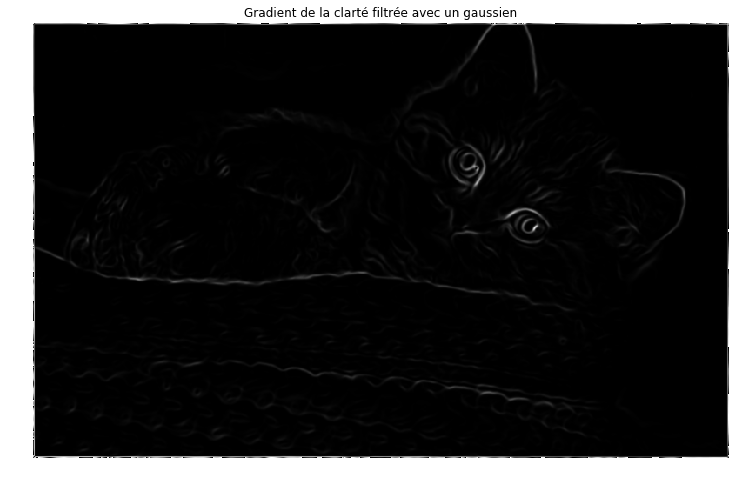

In [15]:
matplotlib.rcParams['figure.figsize'] = (25.0, 8.0)
imshow(f2int(gradient_magnitude), title=f"Gradient de la clarté filtrée avec un gaussien")

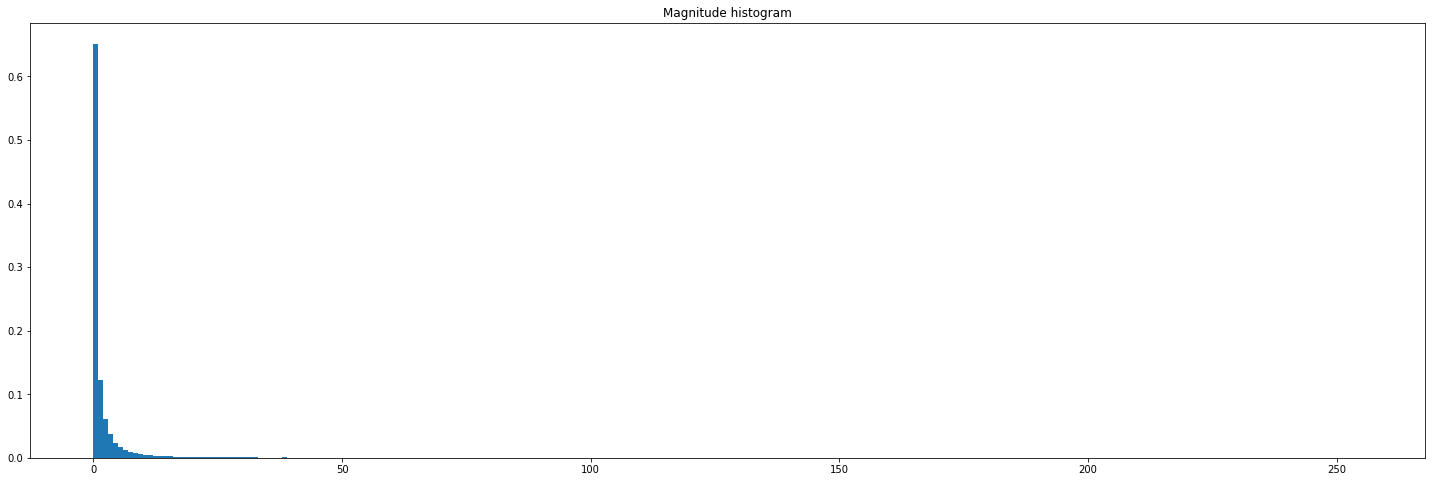

In [16]:
plt.hist(f2int(gradient_magnitude).reshape(-1), bins=255, density=True);
plt.title("Magnitude histogram");

In [17]:
def binariser(img, seuil, invert=True):
    """Issu du TP2"""
    threshold_type = cv2.THRESH_BINARY_INV if invert else cv2.THRESH_BINARY
    _, binary_img = cv2.threshold(img,seuil,255,threshold_type)
    return binary_img.astype(np.bool_)

def seuillage_otsu(img):
    assert img.dtype==np.uint8, "L'image doit être de type uint8"
    thresholds = np.unique(img)
    hist, bins = np.histogram(img, np.arange(256))
    bins = bins[:-1]
    hist = hist/img.size
    nu = 0
    for k in thresholds:
        hist_c1  = hist[:k] # Histogramme du cluster 1
        hist_c2  = hist[k:] # Histogramme du cluster 2
        P1_k = hist_c1.sum() # Probabilité d'appartenir au cluster 1
        P2_k = hist_c2.sum() # A compléter
        if P1_k==0:
            continue
        if P2_k==0:
            break
        m1_k =  np.sum(bins[:k]*hist_c1) / P1_k.astype(np.float32) # Calcul de la moyenne sur le cluster 1
        m2_k =  np.sum(bins[k:]*hist_c2) / P2_k.astype(np.float32) # Calcul de la moyenne sur le cluster 1
        var_interclasse = P1_k * P2_k * (m1_k - m2_k)**2
        if var_interclasse>nu:
            threshold = k
            nu = var_interclasse
    image_seuillee = binariser(img, threshold, invert=False) # À completer
    return image_seuillee



Text(0.5, 1.0, "Extraction de contours de l'image des gradients sans préfiltrage Gaussien")

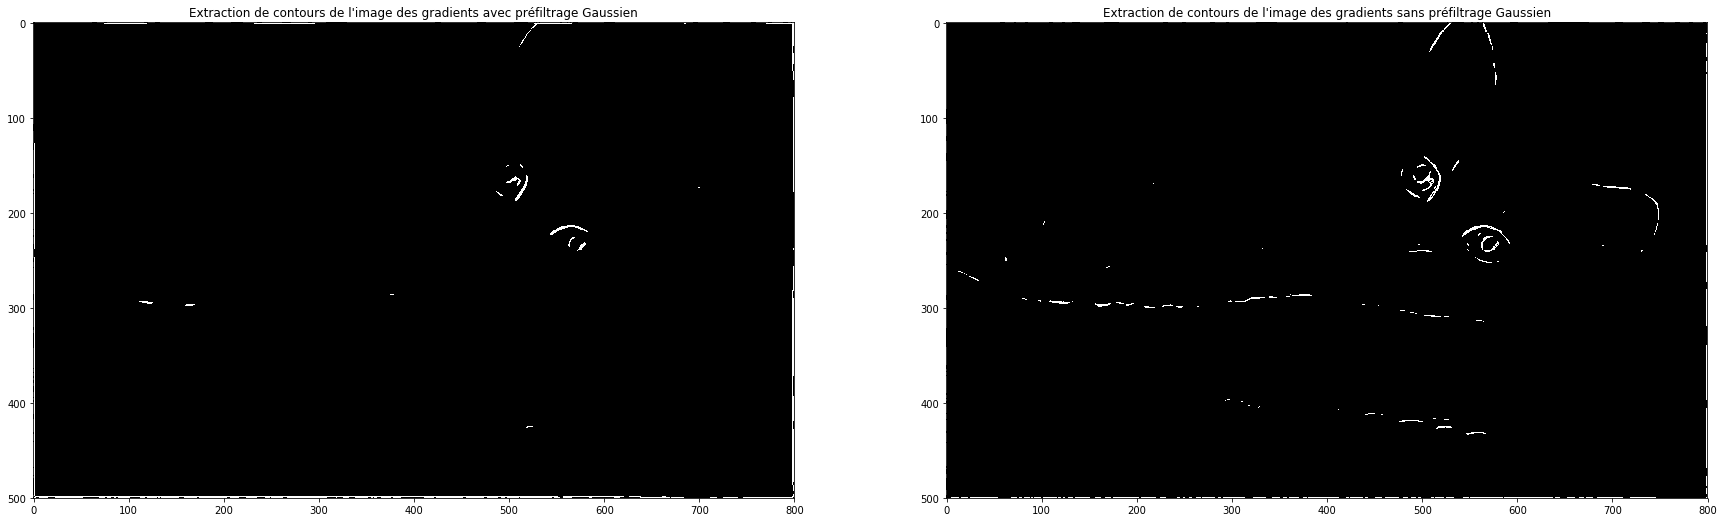

In [18]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(30, 20))

ax[0].imshow(seuillage_otsu(f2int(gradient_magnitude)), vmin=0, vmax=1)
ax[0].set_title("Extraction de contours de l'image des gradients avec préfiltrage Gaussien")

ax[1].imshow(seuillage_otsu(f2int(get_simple_gradients(clearness, show=False))), vmin=0, vmax=1)
ax[1].set_title("Extraction de contours de l'image des gradients sans préfiltrage Gaussien")

**Réponse**: On observe d'abord des discontinuités dans l'image de contours calculés sur l'image originale sans préfiltrage Gaussien. Les contours sont également parfois larges. Dans l'image de contours issu de l'image originale avec préfiltrage Gaussien, on remarque que la majorité des contours sont manquants. 

## Question 7
Vous allez maintenant expérimenter la détection de contours par la méthode de Marr-Hildreth. On rappelle les étapes de la méthode:
* L'image est filtrée avec une gaussienne (fixée par $\sigma$)
* On calcule son Laplacien
* On cherche les passages par zéros du Laplacien. On conserve ceux correspondant à un écart absolu supérieur à un seuil $t<1$

> Le code de la fonction cherchant les passages par zéros vous est fourni. Elle attend en paramètre une image Laplacien et un seuil. 


Affichez les contours pour $\sigma=5$ et un seuil égal à 0.005. Pour le calcul du Laplacien, vous devez créer vous-même le filtre correspondant.
Testez la détection des contours pour différentes valeurs de sigma et de seuil et indiquez l'effet de ces deux paramètres.

In [19]:
def passage_par_zeros(img, seuil):
    out = np.zeros_like(img)
    for i in range(1, img.shape[0]-1):
        for j in range(1, img.shape[1]-1):
            ec = 0
            if img[i-1, j]*img[i+1, j] < 0: # y
                ec = max(ec, np.abs(img[i+1, j]-img[i-1, j]))
            if img[i, j-1]*img[i, j+1] < 0: # x
                ec = max(ec, np.abs(img[i, j+1]-img[i, j-1]))
            if img[i-1, j-1]*img[i+1, j+1] < 0: # diag
                ec = max(ec, np.abs(img[i+1, j+1]-img[i-1, j-1]))
            if img[i+1, j-1]*img[i-1, j+1] < 0: # other diag
                ec = max(ec, np.abs(img[i+1, j-1]-img[i-1, j+1]))
            
            out[i, j] = ec
    
    threshold = seuil*np.max(out)
    return out>threshold


Text(0.5, 1.0, 'Détection de contours avec sigma=5 et seuil=0.005')

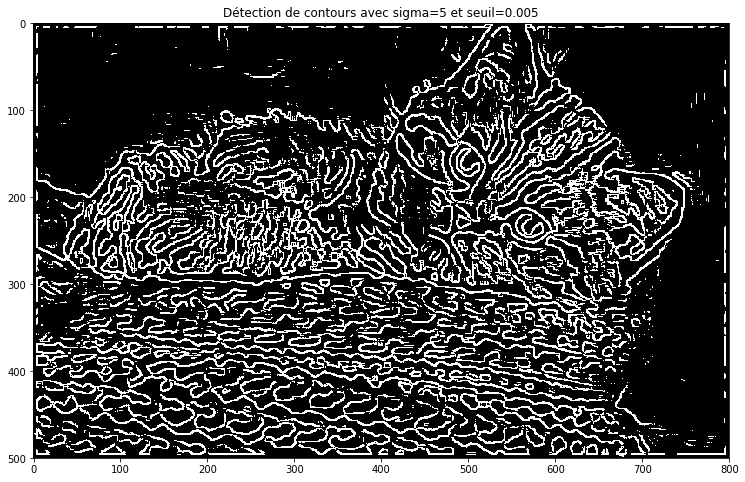

In [20]:
def apply_marr_hildreth(img, threshold, gaussian_sigma):
    LAPLACIEN_MASK = np.array([
        [-1, -1, -1],
        [-1,  8, -1],
        [-1, -1, -1],
    ])
    GAUSSIAN_KERNEL_SIZE = (9, 9)
    
    gaussian_filtered_img = get_gaussian_filtered(img, GAUSSIAN_KERNEL_SIZE, sigma=gaussian_sigma)
    laplacian_img = scipy.signal.convolve2d(gaussian_filtered_img, LAPLACIEN_MASK, mode='same')
    
    return passage_par_zeros(laplacian_img, threshold)
    
edges_marr_hildreth = apply_marr_hildreth(clearness, 0.005, 5)
plt.imshow(edges_marr_hildreth, vmin=0, vmax=1)
plt.title('Détection de contours avec sigma=5 et seuil=0.005')

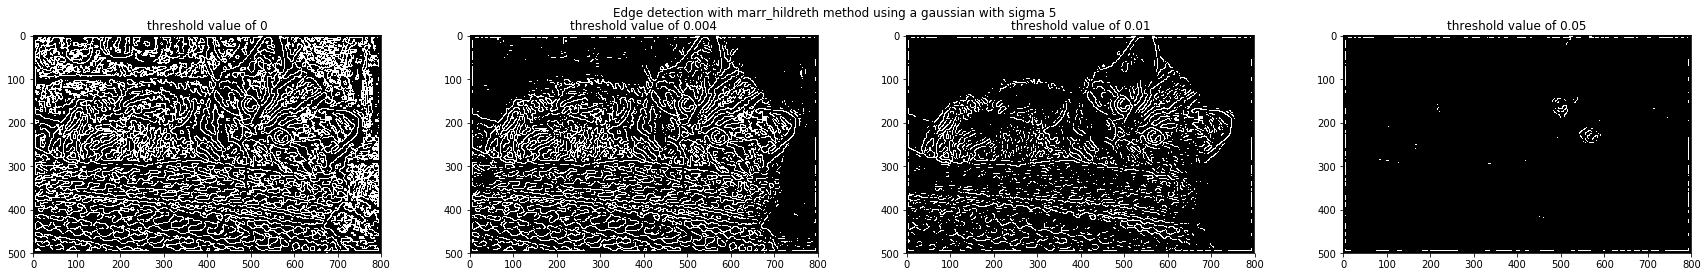

In [21]:
sigma = 5
thresholds = [0, 0.004, 0.01, 0.05]
fig, ax = plt.subplots(ncols=len(thresholds), nrows=1, figsize=(30, 4))

for idx, threshold in enumerate(thresholds):
    
    edges_marr_hildreth = apply_marr_hildreth(clearness, threshold, sigma)
    ax[idx].imshow(edges_marr_hildreth, vmin=0, vmax=1)
    ax[idx].set_title(f'threshold value of {threshold}')
    
fig.suptitle(f'Edge detection with marr_hildreth method using a gaussian with sigma {sigma}');

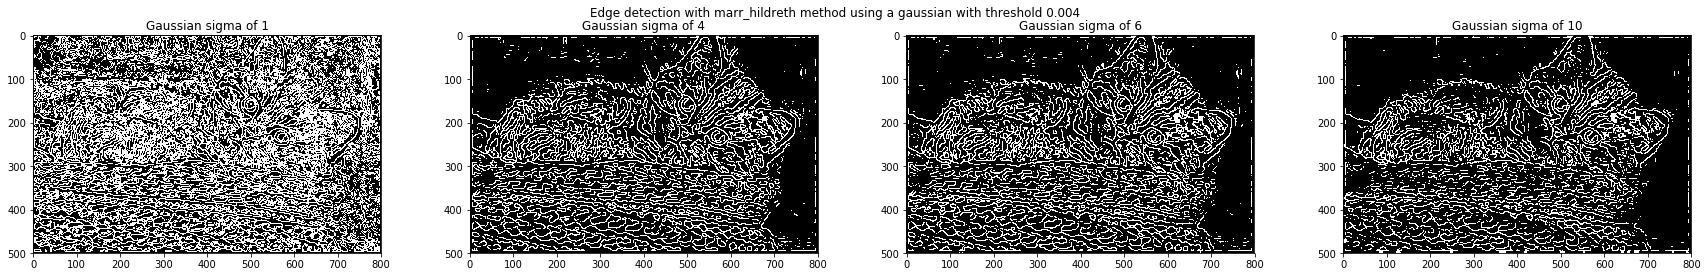

In [22]:
sigmas = [1, 4, 6, 10]
threshold = 0.004
fig, ax = plt.subplots(ncols=len(sigmas), nrows=1, figsize=(30, 4))

for idx, sigma in enumerate(sigmas):
    
    edges_marr_hildreth = apply_marr_hildreth(clearness, threshold, sigma)
    ax[idx].imshow(edges_marr_hildreth, vmin=0, vmax=1)
    ax[idx].set_title(f'Gaussian sigma of {sigma}')
    
fig.suptitle(f'Edge detection with marr_hildreth method using a gaussian with threshold {threshold}');

**Réponse**: 
- La valeur du seuil influence d'abord la quantité de contours retenue dans l'image de contours finale. Plus la valeur est petite, plus il se trouvera de contours dans l'image de contour, et plus elle est grande, moins il s'en trouvera. On voit également l'effet spaghetti (beaucoup de contours, même dans les sections de couleur unie dans l'image originale) quand on ne fixe pas de seuil, soit quand il est à 0.
- La valeur de l'écart type du Gaussien influence le nombre de contours présent dans l'image finale. En effet, comme il permet de diminuer l'intensité des hautes fréquences de l'image originale si on en augmente la valeur, il influence alors le nombre de contours dans l'image de contours. S'il est petit, il se trouvera alors beaucoup de petits contours discontinus dans l'image, et s'il est grand, il y en aura moins, ou pas.

## Question 8

Enfin, pour compléter votre tour d'horizon des méthodes de détection de contours, vous allez utiliser la méthode de Canny. L'implémentation n'est pas demandée: vous pouvez vous servir de la méthode d'**openCV** de la manière suivante:

```python
edges_canny = cv2.Canny(clarte, min_hysteresis, max_hysteresis) # clarte doit être en uint8
```
où min_hysteresis, max_hysteresis représentent respectivement les seuils bas et haut du filtrage par hystérésis.
En partant d'un seuil haut à 100, comparez l'effet de différentes valeurs de seuils bas et discutez du résultat.

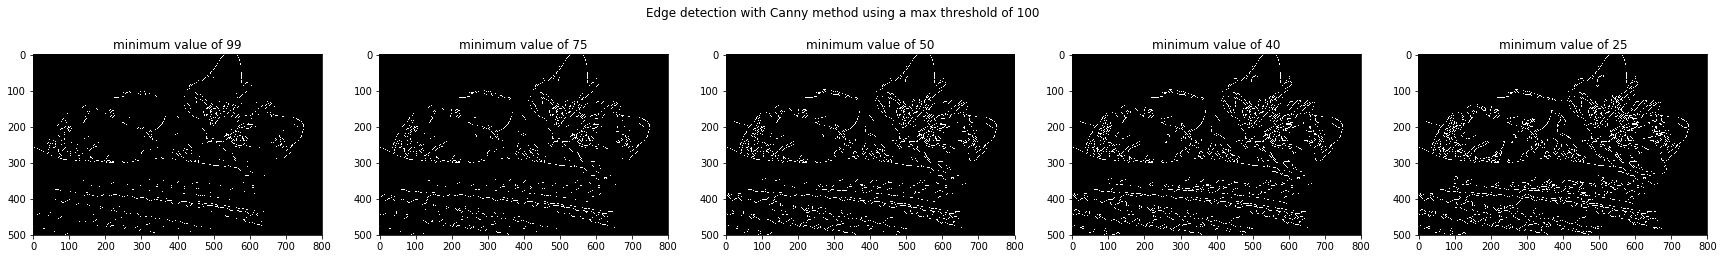

In [23]:
max_hysteresis = 100
min_hysteresis = [99, 75, 50, 40, 25]
fig, ax = plt.subplots(ncols=len(min_hysteresis), nrows=1, figsize=(30, 4))

for idx, min_hyst in enumerate(min_hysteresis):
    edges_canny = cv2.Canny(f2int(clearness), min_hyst, max_hysteresis)
    ax[idx].imshow(edges_canny, vmin=0, vmax=1)
    ax[idx].set_title(f'minimum value of {min_hyst}')
    
fig.suptitle(f'Edge detection with Canny method using a max threshold of {max_hysteresis}');

**Réponse**: On voit que plus on réduit le seuil minimum, plus il se trouve de contours, et mois les contours semblent discontinus. En effet, cela concorde avec l'utilisation qui en est fait, comme le seuil minimal définit le seuil à partir duquel on peut accepter de mettre à 1 un pixel contigüe, et dans une même direction, que l'on avait préalablement filtré. 

## Question 9
Affichez sur un subplots 2x2 les contours obtenus (Otsu sur gradient sans gaussienne et avec gaussienne, avec la méthode de Marr-Hildreth et avec la méthode de Canny). Commentez leurs effets respectifs et leur flexibilité.


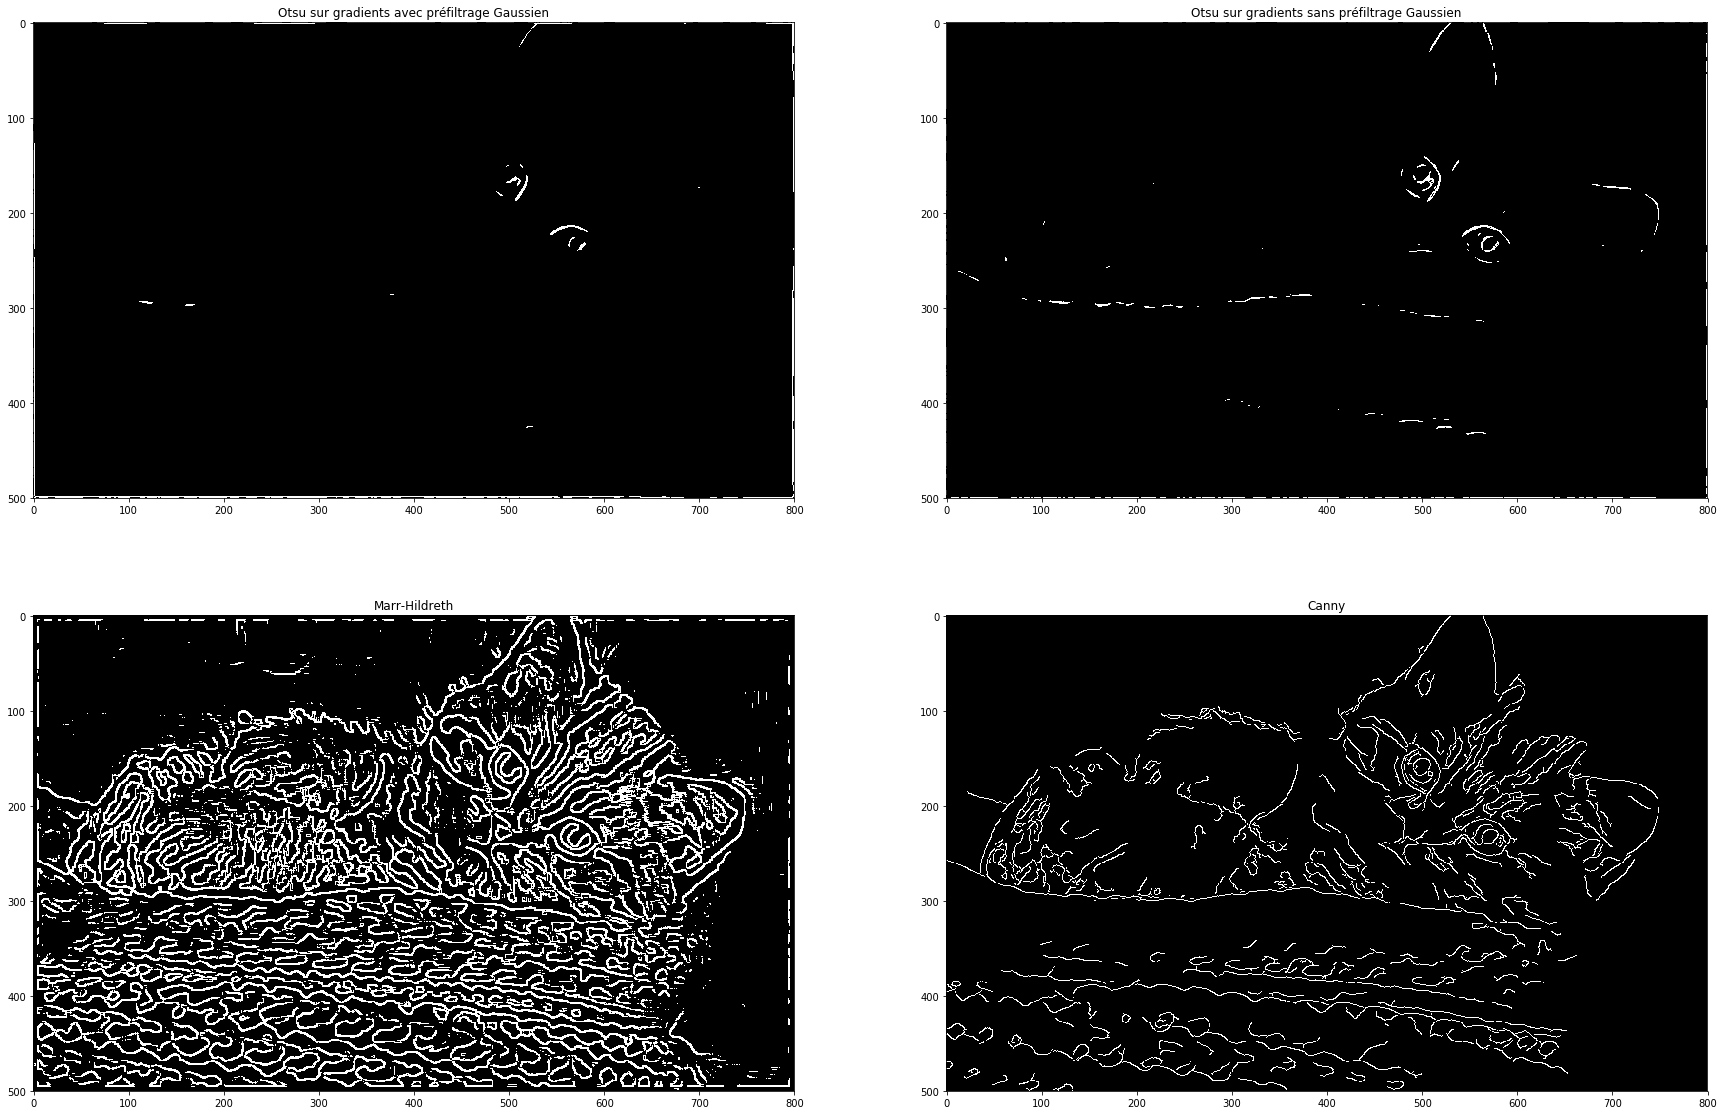

In [24]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(30, 20))

ax[0][0].imshow(seuillage_otsu(f2int(gradient_magnitude)), vmin=0, vmax=1)
ax[0][0].set_title("Otsu sur gradients avec préfiltrage Gaussien")

ax[0][1].imshow(seuillage_otsu(f2int(get_simple_gradients(clearness, show=False))), vmin=0, vmax=1)
ax[0][1].set_title("Otsu sur gradients sans préfiltrage Gaussien")

ax[1][0].imshow(apply_marr_hildreth(clearness, 0.005, 5), vmin=0, vmax=1)
ax[1][0].set_title("Marr-Hildreth")

ax[1][1].imshow(cv2.Canny(f2int(clearness), 100, 40), vmin=0, vmax=1)
ax[1][1].set_title("Canny");

**Réponse**:
- Méthode Otsu: 
    Cette méthode est la moins flexible et celle qui offre les moins bons résultats. En effet, dans les deux cas, il se trouve peu de contours, et ceux-ci sont discontinus. On peut expliquer cela par le fait que la binarisation ne se base que sur l'histogramme, l'emplacement des pixels n'étant pas considéré. On se trouve donc avec des contours discontinus, et plusieurs petites sections isolées, dans le  cas où l'on fait un préfiltrage gaussien et non.
    
    - Sans préfiltrage Gaussien:
    
    Cette méthode se base sur le calcul de gradients sur l'image originale. Elle n'est pas flexible, comme c'est une approche qui n'a pas de paramètre. Comparativement à l'image de contour avec préfiltrage gaussien, on voit qu'on se retrouve avec plus de contours.
    
    - Avec préfiltrage Gaussien:
    
    Cette méthode est la même, mais en ajoutant une étape de lissage de l'image originale avec un filtre passe-bas gaussien. Dans ce cas-ci, on peut modifier l'écart-type du filtre, avec $\sigma$, et on peut modifier la taille du filtre. On peut donc dire que cette méthode est plus flexible que la méthode sans préfiltrage.
    
- Approche Marr-Hildreth:

    Cette méthode est plus flexible que la méthode d'Otsu, comme en plus d'avoir à paramétriser le filtre gaussien ($\sigma$ et la taille du filtre), on peut également paramétriser le seuil pour lequel on conserve un contour. On voit, dans l'image obtenue, qu'il se trouve beaucoup plus de contours. Certains ne sont pas nécessaires (par exemple au niveau de l'arrière-plan), et encore une fois, discontinus.

- Approche Canny:

    Cette méthode est également flexible. En effet, on peut modifier deux seuils, soit un seuil maximal et minimal. Il est alors possible d'avoir un bon contrôle sur la quantité de contours à conserver, selon l'intensité des contours. Cette technique permet d'obtenir des contours continus et unidimensionnel, soit que la largeur des contours se limitent à 1 pixel. Elle donne les meilleurs résultats.

# Partie 2

Cette partie manipule les images couleurs. Repartez donc de l'image chargée à la toute première question de la partie 1

## Question 10
Chargez l'image **chat.png**, filtrez-la avec un filtrage médian de taille 9, convertissez-la en valeur flottantes et affichez-la. 

Valeurs de la première ligne de pixel:
 [[[0.3019608  0.42745098 0.5882353 ]
  [0.3019608  0.42745098 0.5882353 ]
  [0.3019608  0.42745098 0.5882353 ]
  ...
  [0.7490196  0.74509805 0.7607843 ]
  [0.7490196  0.74509805 0.7607843 ]
  [0.7490196  0.74509805 0.7607843 ]]] 



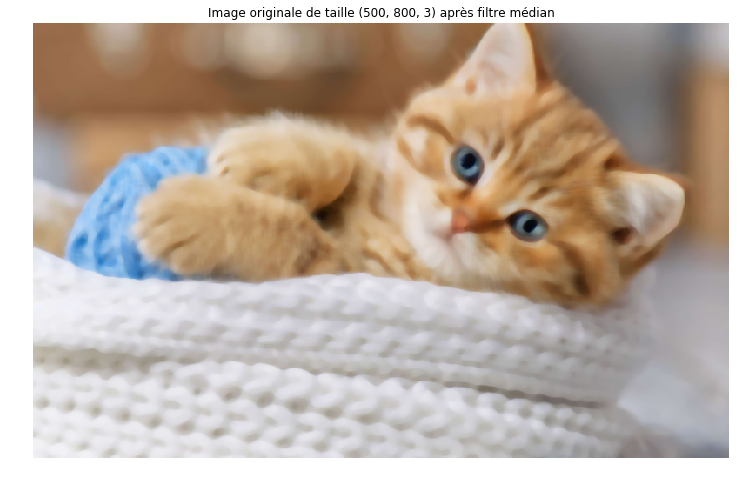

In [25]:
img = cv2.imread('data/chaton.png')
img = int2f(img)

win_size = 9
img = int2f(cv2.medianBlur(f2int(img), win_size))

print("Valeurs de la première ligne de pixel:\n", img[0:1,], '\n')
imshow(f2int(img), title=f'Image originale de taille {img.shape} après filtre médian', is_bgr=True)

Une photographie contient beaucoup plus de couleurs qu'un dessin. Nous allons effectuer une opération de **postérisation** consistant à réduire le nombre de couleurs contenues dans une image. Nous allons pour cela comparer différentes approches.

### Postérisation naive

Pour cette méthode, on recense toutes les N couleurs distinctes contenues dans l'image sous la forme d'un tableau $T_1$ de taille $N\times 3$. Par la suite, on ne garde que les K couleurs les plus présentes dans l'image de telle sorte à obtenir un tableau $T_2$ de taille $K \times 3$. 

Pour chaque pixel de l'image originale, on remplace alors sa couleur par celle qui lui est la plus proche dans le tableau $T_2$. La notion de proximité est définie en utilisant la distance euclidienne.



## Question 11
Implémentez la fonction
```python 
def recenser_couleurs(img):
    ...
    return couleurs_uniques, comptes 

```
Qui renvoie un tableau de couleurs uniques dans une image ainsi que le nombre de pixels associé à chacune. 

In [26]:
def recenser_couleurs(img):
    img_int = f2int(img)
    couleurs_uniques, comptes = np.unique(img_int.reshape(-1,3), return_counts=True, axis=0)

    return couleurs_uniques, comptes 

In [27]:
couleurs_uniques, comptes = recenser_couleurs(img)
couleurs_uniques, comptes

(array([[  4,  12,  25],
        [  4,  15,  28],
        [  4,  16,  31],
        ...,
        [249, 242, 241],
        [250, 208, 159],
        [250, 210, 166]], dtype=uint8), array([2, 2, 1, ..., 2, 1, 1]))

## Question 12
Complétez les fonctions:

```python
def distance_euclienne(col1, col2):
    """
    Cette fonction prend en entrée deux tableaux de couleurs et renvoie le tableau des distances entre chacune d'entre elles
    :param col1: Tableau de taille Nx3
    :param col2: Tableau de taille Mx3
    :return d: Tableau des distances euclidiennes de taille NxM

    """
    ...
    return d

def posterisation_naive(img, K=32):
    h, w, c = img.shape
    col_uniques, comptes = recenser_couleurs(img)
    T2 = ... # A compléter: on ne garde que K les couleurs de col_uniques les + présentes
    distances = distance_euclienne(T2,  img.reshape(-1, c))
    indices_d_minimale = ... # On récupère pour chaque pixel l'indice qui va nous donner la nouvelle couleur dans T2.
    posterisation = ...
    return posterisation.reshape(h, w, c)
    
```

In [28]:
def distance_euclienne(col1, col2):
    """
    Cette fonction prend en entrée deux tableaux de couleurs et renvoie le tableau des distances entre chacune d'entre elles
    :param col1: Tableau de taille Nx3
    :param col2: Tableau de taille Mx3
    :return d: Tableau des distances euclidiennes de taille NxM

    implementation inspired by this definition of a euclidean distance matrix example over 2D matrices
    https://medium.com/swlh/euclidean-distance-matrix-4c3e1378d87f
    """
    # holds the [[a_11^2 + a_12^2 + a_13^2], ..., [a_n1^2 + a_n2^2 + a_n3^2]] of shape (N, 1)
    col1_powers = np.sum(col1**2, axis=1).reshape(-1,1)
    
    # holds the [a_11^2 + a_12^2 + a_13^2, ..., a_n1^2 + a_n2^2 + a_n3^2] of shape (M,)
    col2_powers = np.sum(col2**2, axis=1)
    
    # holds the [[-2a_1*T(b_1)], [-2a_2*T(b_2)], ...] of shape (N, M)
    differences_product = -2*np.dot(col1, col2.T)

    # by adding a (N,1) with a (M) matrix, it multiplies both matrixes to have a (N,M), to which we add the differences product
    return np.sqrt(col1_powers + col2_powers + differences_product)

In [29]:
def posterisation_naive(img, K=32):
    h, w, c = img.shape
    col_uniques, comptes = recenser_couleurs(img)
    
    T2 = int2f(col_uniques[np.argsort(comptes)[::-1]][:K]) # A compléter: on ne garde que K les couleurs de col_uniques les + présentes
    
    distances = distance_euclienne(T2,  img.reshape(-1, c)) 
    
    indices_d_minimale = np.argmin(distances, axis=0) # On récupère pour chaque pixel l'indice qui va nous donner la nouvelle couleur dans T2.

    posterisation = T2[indices_d_minimale]
    
    print("Nombre de pixels ayant la couleur des 64 couleurs les plus fréquentes: ", comptes[np.argsort(comptes)[::-1]][:K].sum())
    print("Nombre de pixels dont la distance est inférieure à 0.005: ",(distances <= 0.002).sum())

    return posterisation.reshape(h, w, c)

## Question 13
Testez et affichez le résultat de la fonction avec K=64. Qu'observez-vous et qu'en concluez-vous sur la postérisation naive?

In [30]:
result = posterisation_naive(img, K=64)

/Users/claudiaonorato/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt


Nombre de pixels ayant la couleur des 64 couleurs les plus fréquentes:  29950
Nombre de pixels dont la distance est inférieure à 0.005:  27899


/Users/claudiaonorato/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less_equal
  


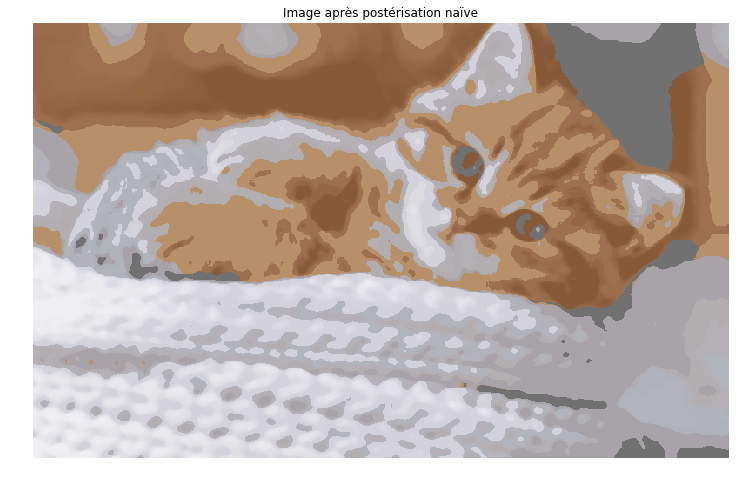

In [31]:
imshow(f2int(result), title="Image après postérisation naïve", is_bgr=True)

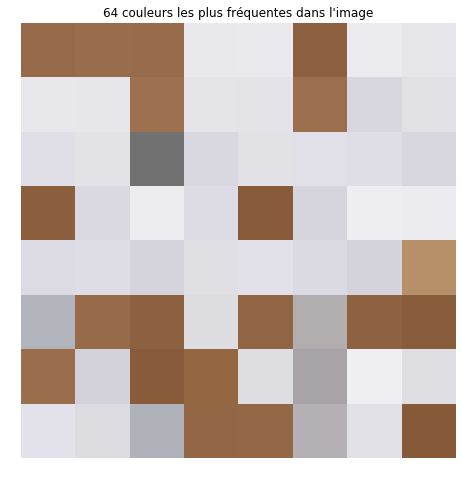

In [32]:
imshow(
    couleurs_uniques[np.argsort(comptes)[::-1]][:64].reshape(8, 8, 3),
    title="64 couleurs les plus fréquentes dans l'image",
    is_bgr=True
)

**Réponse**: Les couleurs sélectionnées, soit les 64 plus fréquentes, ont des teintes très similaires. En effet, on distingue que du brun et du gris dans l'image avec postérisation naïve. L'image résultante est alors très différentes de l'image originale, comme certaines teintes ne s'y trouvent plus.

## Question 14
Pour corriger les défauts de la postérisation naive, nous allons utiliser une manière plus sophistiquée de réduire le nombre de couleurs. Plutôt que ne garder que les plus présentes, nous allons regrouper chaque couleur en K paquets (appelés clusters) de telle sorte que chaque paquet contiennent les couleurs qui lui sont les plus proches. Notre nouveau tableau $T2$ sera alors constitué des moyennes de chaque paquet. Cet algorithme est appelé *K-moyennes* (K-mean) et il est fondamental en IA. 

Mais pas de panique, vous n'avez pas à l'implémenter! Vous pouvez simplement utiliser la version fournie par la librairie scipy:
```python
from scipy.cluster.vq import kmeans
T2 = kmeans(T1, K)[0] # K est le nombre de couleurs que l'on souhaite garder, T1 le tableau de couleurs uniques.
```

Implémentez la fonction
```python
def posterisation_kmeans(img, K=8):
    ...
```
De telle sorte à utiliser l'algorithme *kmeans* pour le calcul de T2. Affichez les résultats pour K=2,K=8 et K=64. Qu'en concluez-vous?

In [33]:
def posterisation_kmeans(img, K=8):
    h, w, c = img.shape
    col_uniques, comptes = recenser_couleurs(img)
    
    T2 = scipy.cluster.vq.kmeans(int2f(col_uniques), K)[0]
    
    distances = distance_euclienne(T2,  img.reshape(-1, c)) 
    
    indices_d_minimale = np.argmin(distances, axis=0) # On récupère pour chaque pixel l'indice qui va nous donner la nouvelle couleur dans T2.

    posterisation = T2[indices_d_minimale]
    
    print("Nombre de pixels ayant la couleur des 64 couleurs les plus fréquentes: ", comptes[np.argsort(comptes)[::-1]][:K].sum())
    print("Nombre de pixels dont la distance est inférieure à 0.005: ",(distances <= 0.002).sum())

    return posterisation.reshape(h, w, c)

Nombre de pixels ayant la couleur des 64 couleurs les plus fréquentes:  2488
Nombre de pixels dont la distance est inférieure à 0.005:  2
Nombre de pixels ayant la couleur des 64 couleurs les plus fréquentes:  7215
Nombre de pixels dont la distance est inférieure à 0.005:  16
Nombre de pixels ayant la couleur des 64 couleurs les plus fréquentes:  29950
Nombre de pixels dont la distance est inférieure à 0.005:  226


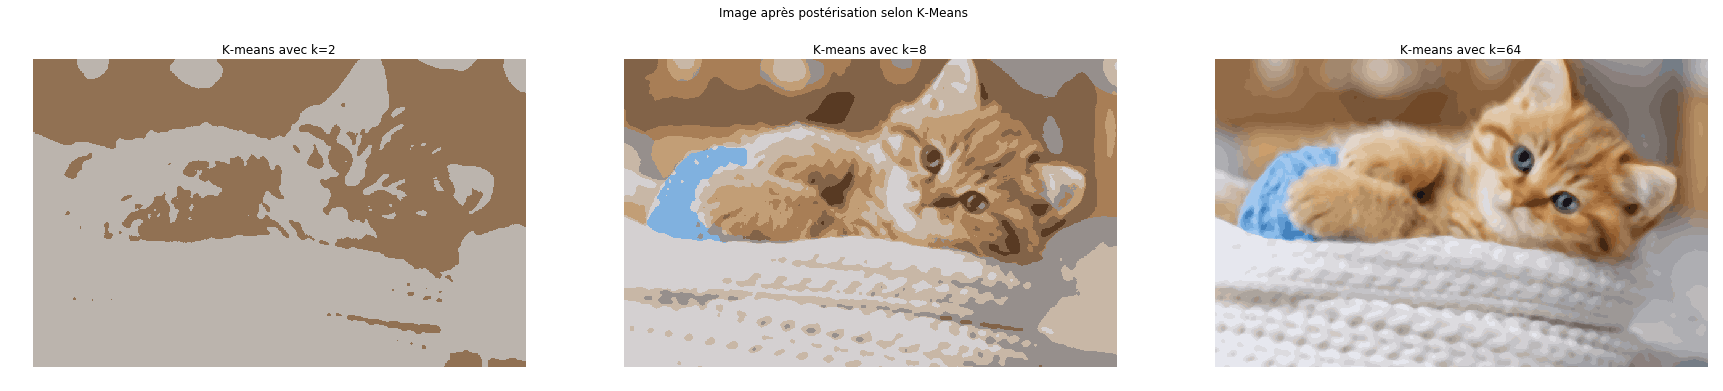

In [34]:
nb_colors = [2, 8, 64]

fig, ax = plt.subplots(ncols=len(nb_colors), nrows=1, figsize=(30, 6))

for idx, nb in enumerate(nb_colors):
    result_kmeans = posterisation_kmeans(img, K=nb)
    imshow(f2int(result_kmeans), title=f"K-means avec k={nb}", is_bgr=True, ax=ax[idx])
    
fig.suptitle(f'Image après postérisation selon K-Means');

**Réponse**: On peut voir que le nombre de groupe formé par l'algorithme k-means est indiqué par le paramètre k. Dans notre cas, cela se réflète par le nombre de couleur affichée dans l'image postérisée. Le résultat est bien meilleur qu'avec la méthode naïve, comme les couleurs sélectionnées représentent, du mieux possible, tous les pixels de l'image, ce pourquoi, même pour un petit nombre de groupes, il y a tout de même la couleur bleue qui a été sélectionnée.

## Question 15

Dans les cas précédents, on a postérisé l'image sans considérations sur l'importance de certaines couleurs par rapport à d'autres. Cependant en général, sur un dessin, une palette de couleurs contient beaucoup plus de teintes différentes que de saturations ou d'intensités différentes (dans une boîte de crayon de couleur, il existe en général une dizaine de teinte différentes mais rarement plus de deux saturations et/ou intensités par teinte). 

Nous allons mimer ce phénomème en postérisant nos canaux indépendamment. En vous inspirant des questions précédentes, implémentez la fonction:
```python
def posterize_grayscale(canal, K=8):
    ...
```
qui permet de postériser un seul canal (par la méthode kmean).



In [35]:
def posterisation_grayscale(canal, K=8):
    h, w = canal.shape
    T1 = canal.reshape(-1)
    
    col_uniques, comptes = np.unique(f2int(T1), return_counts=True, axis=0)
    
    T2 = scipy.cluster.vq.kmeans(int2f(col_uniques), K)[0]
    
    distances = distance_euclienne(T2.reshape(-1, 1),  T1.reshape(-1, 1))
        
    indices_d_minimale = np.argmin(distances, axis=0) # On récupère pour chaque pixel l'indice qui va nous donner la nouvelle couleur dans T2.

    posterisation = T2[indices_d_minimale]
    
    print("Nombre de pixels ayant la couleur des 64 couleurs les plus fréquentes: ", comptes[np.argsort(comptes)[::-1]][:K].sum())
    print("Nombre de pixels dont la distance est inférieure à 0.005: ",(distances <= 0.002).sum())

    return posterisation.reshape(h, w)

Nombre de pixels ayant la couleur des 64 couleurs les plus fréquentes:  22115
Nombre de pixels dont la distance est inférieure à 0.005:  21242
Nombre de pixels ayant la couleur des 64 couleurs les plus fréquentes:  26377
Nombre de pixels dont la distance est inférieure à 0.005:  19657


/Users/claudiaonorato/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/Users/claudiaonorato/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less_equal
  app.launch_new_instance()


Nombre de pixels ayant la couleur des 64 couleurs les plus fréquentes:  33594
Nombre de pixels dont la distance est inférieure à 0.005:  19399


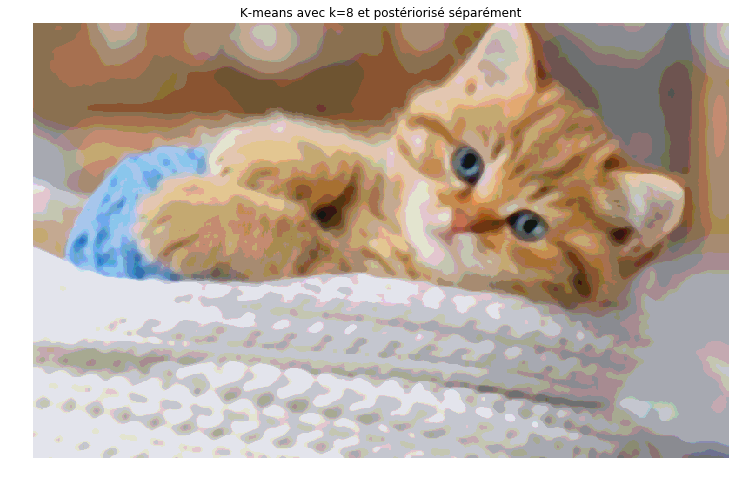

In [36]:
img_seperate = img.copy()
img_seperate[:,:,0] = posterisation_grayscale(img_seperate[:,:,0], K=8)
img_seperate[:,:,1] = posterisation_grayscale(img_seperate[:,:,1], K=8)
img_seperate[:,:,2] = posterisation_grayscale(img_seperate[:,:,2], K=8)

imshow(f2int(img_seperate), title=f"K-means avec k=8 et postériorisé séparément", is_bgr=True)

## Question 16
Nous allons utiliser un espace de couleurs très similaires au HSI qui est le HSV (Hue/Saturation/Value). 
Pour convertir une image RGB en HSV et réciproquement, utilisez la fonction opencv:
```python
hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

```
Affichez les trois canaux H, S et V séparément et commentez le résultat. Dans quels intervalles de valeurs se situent chaque canal?

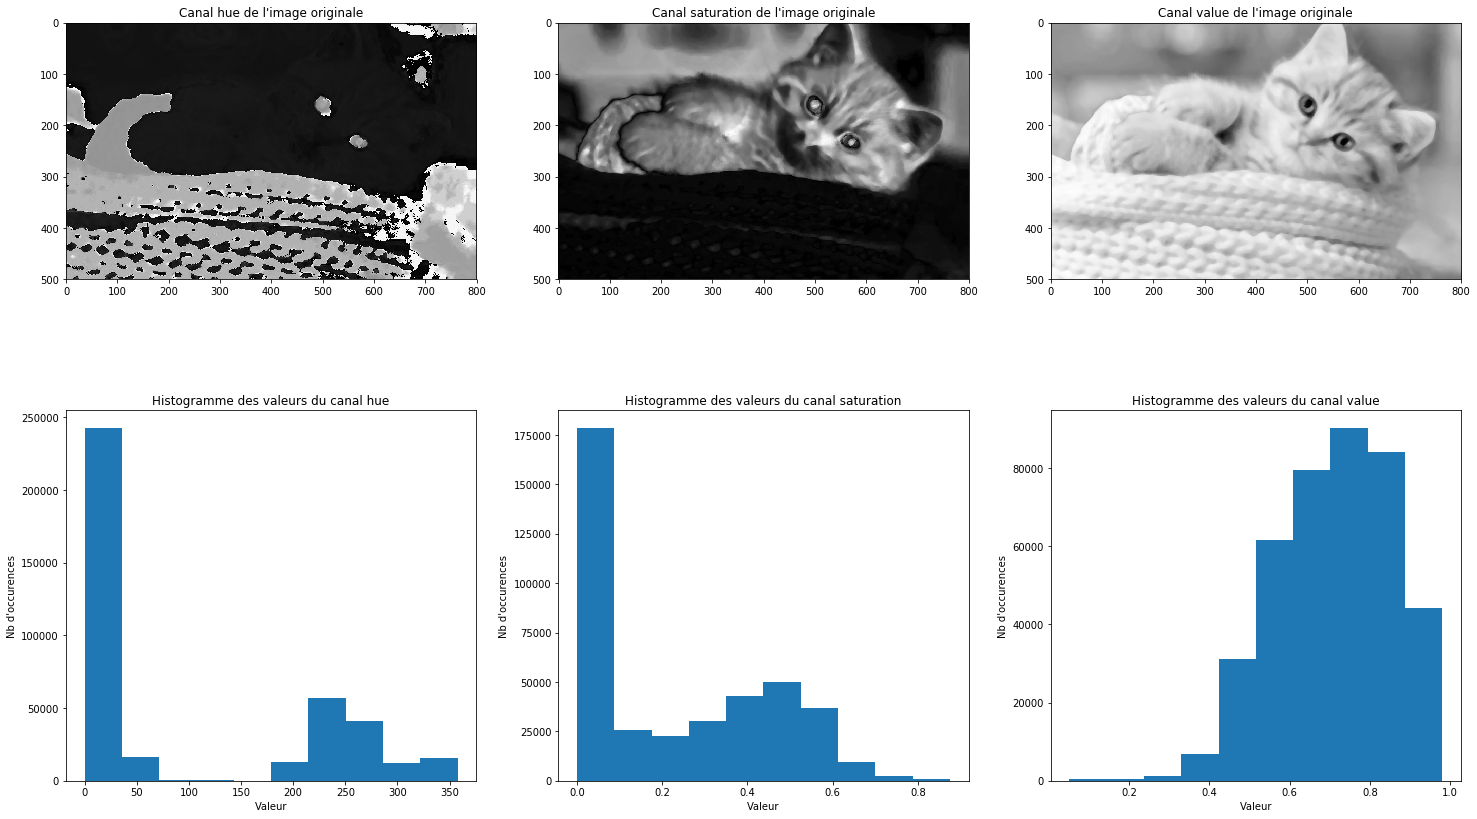

In [37]:
hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(25, 15))

for idx, canal in enumerate(['hue', 'saturation', 'value']):
    img_canal = hsv_img[:,:,idx]

    ax[0][idx].imshow(img_canal, vmin=np.min(img_canal.reshape(-1)), vmax=np.max(img_canal.reshape(-1)))
    ax[0][idx].set_title(f"Canal {canal} de l'image originale")
    
    ax[1][idx].hist(img_canal.reshape(-1))
    ax[1][idx].set_xlabel('Valeur')
    ax[1][idx].set_ylabel("Nb d'occurences")
    ax[1][idx].set_title(f"Histogramme des valeurs du canal {canal}")

plt.show()

**Réponse**:

- Si l'on regarde d'abord la première colonne, soit l'image et l'histogramme des valeurs du canal de la teinte (ou hue), on voit d'abord que les valeurs sont comprises entre 0 et environ 360. En effet, le canal de teinte est représentée, dans le modèle HSI, par un angle sur 360 degré. Si l'on regarde l'image, on voit que la couverture a la même couleur pure, de même que le chaton et l'arrière-plan, qui sont brûnatre. Les pixels de la balle sont également d'environ les mêmes valeurs que les yeux, comme tous les deux sont bleus.

- Ensuite, si l'on regarde le canal de saturation, on voit que les valeurs sont entre 0 et 1, qui indique la pureté de la couleur. Ayant beaucoup de blanc dans l'image, ce canal est alors composé de beaucoup de zéro, surtout au niveau de la couverture. Ailleurs dans l'image, soit en regardant le chaton, l'arrière-plan et la balle, la saturation est non nulle, comme les couleurs sont plus vives.

- Finalement, le canal value, ou intensité, indique si le pixel est clair ou foncé, et a des valeurs entre 0 et 1. Plus la valeur est proche de zéro, plus le pixel est clair. L'image étant bien éclairé et comprenant beaucoup de blanc, nous avons alors des valeurs plus proches de 1, sauf où il y a de l'ombre, par exemple dans les oreilles.

## Question 17
Postérisez chaque canal indépendamment de telle sorte que:
- Le canal de teinte ne contienne plus que 8 éléments différents
- Le canal de saturation n'en contienne plus que 3
- Le canal de valeur n'en contienne plus que 3

Puis reconstruisez l'image à partir des canaux postérisés.

Quel est le nombre théorique maximal de couleurs uniques que peut contenir l'image avec ces contraintes? En pratique, combien de couleurs contient votre image après cette postérisation?

Nombre de pixels ayant la couleur des 64 couleurs les plus fréquentes:  196161
Nombre de pixels dont la distance est inférieure à 0.005:  4264
Nombre de pixels ayant la couleur des 64 couleurs les plus fréquentes:  64039
Nombre de pixels dont la distance est inférieure à 0.005:  3677
Nombre de pixels ayant la couleur des 64 couleurs les plus fréquentes:  12657
Nombre de pixels dont la distance est inférieure à 0.005:  7567


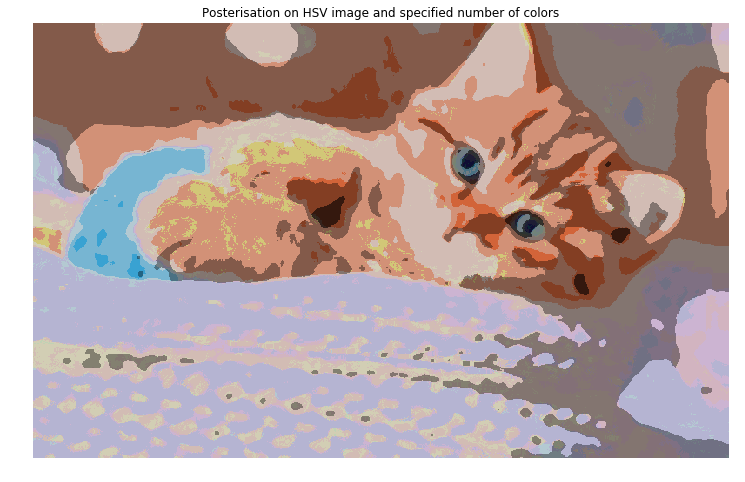

In [38]:
hsv_img_post = hsv_img.copy()
hsv_img_post[:,:,0] = posterisation_grayscale(hsv_img_post[:,:,0]/360, K=8) * 360
hsv_img_post[:,:,1] = posterisation_grayscale(hsv_img_post[:,:,1], K=3)
hsv_img_post[:,:,2] = posterisation_grayscale(hsv_img_post[:,:,2], K=3)

final_img = f2int(cv2.cvtColor(hsv_img_post, cv2.COLOR_HSV2BGR))
imshow(f2int(cv2.cvtColor(hsv_img_post, cv2.COLOR_HSV2BGR)), title=f"Posterisation on HSV image and specified number of colors", is_bgr=True)

In [39]:
print("Nombre de couleur unique: ", len(np.unique(final_img.reshape(-1,3), axis=0)))

Nombre de couleur unique:  44


**Réponse**: Le nombre théorique unique que peut contenir l'image correspond à 3 * 3 * 8 = 72 couleurs uniques. En pratique, le nombre de couleurs contenues dans l'image est de 44.

## Question 18
Et pour finir, complétons notre dessin en ajoutant les contours que nous avons déjà calculés dans la partie 1 à notre image!
> Pour faire cela, vous pouvez aussi bien utiliser l'indexation (mettre à 0 les valeurs de contours sur l'image), la multplication élément par élément ou encore un bitwise_xor... Libre à vous de choisir la méthode qui vous arrange!


Créez quatre subplots et affichez les différents contours (gradients, canny, méthode LoG...) en noir par dessus l'image postérisée calculée à la question précédente.
Laquelle vous paraît fournir le meilleur résultat?

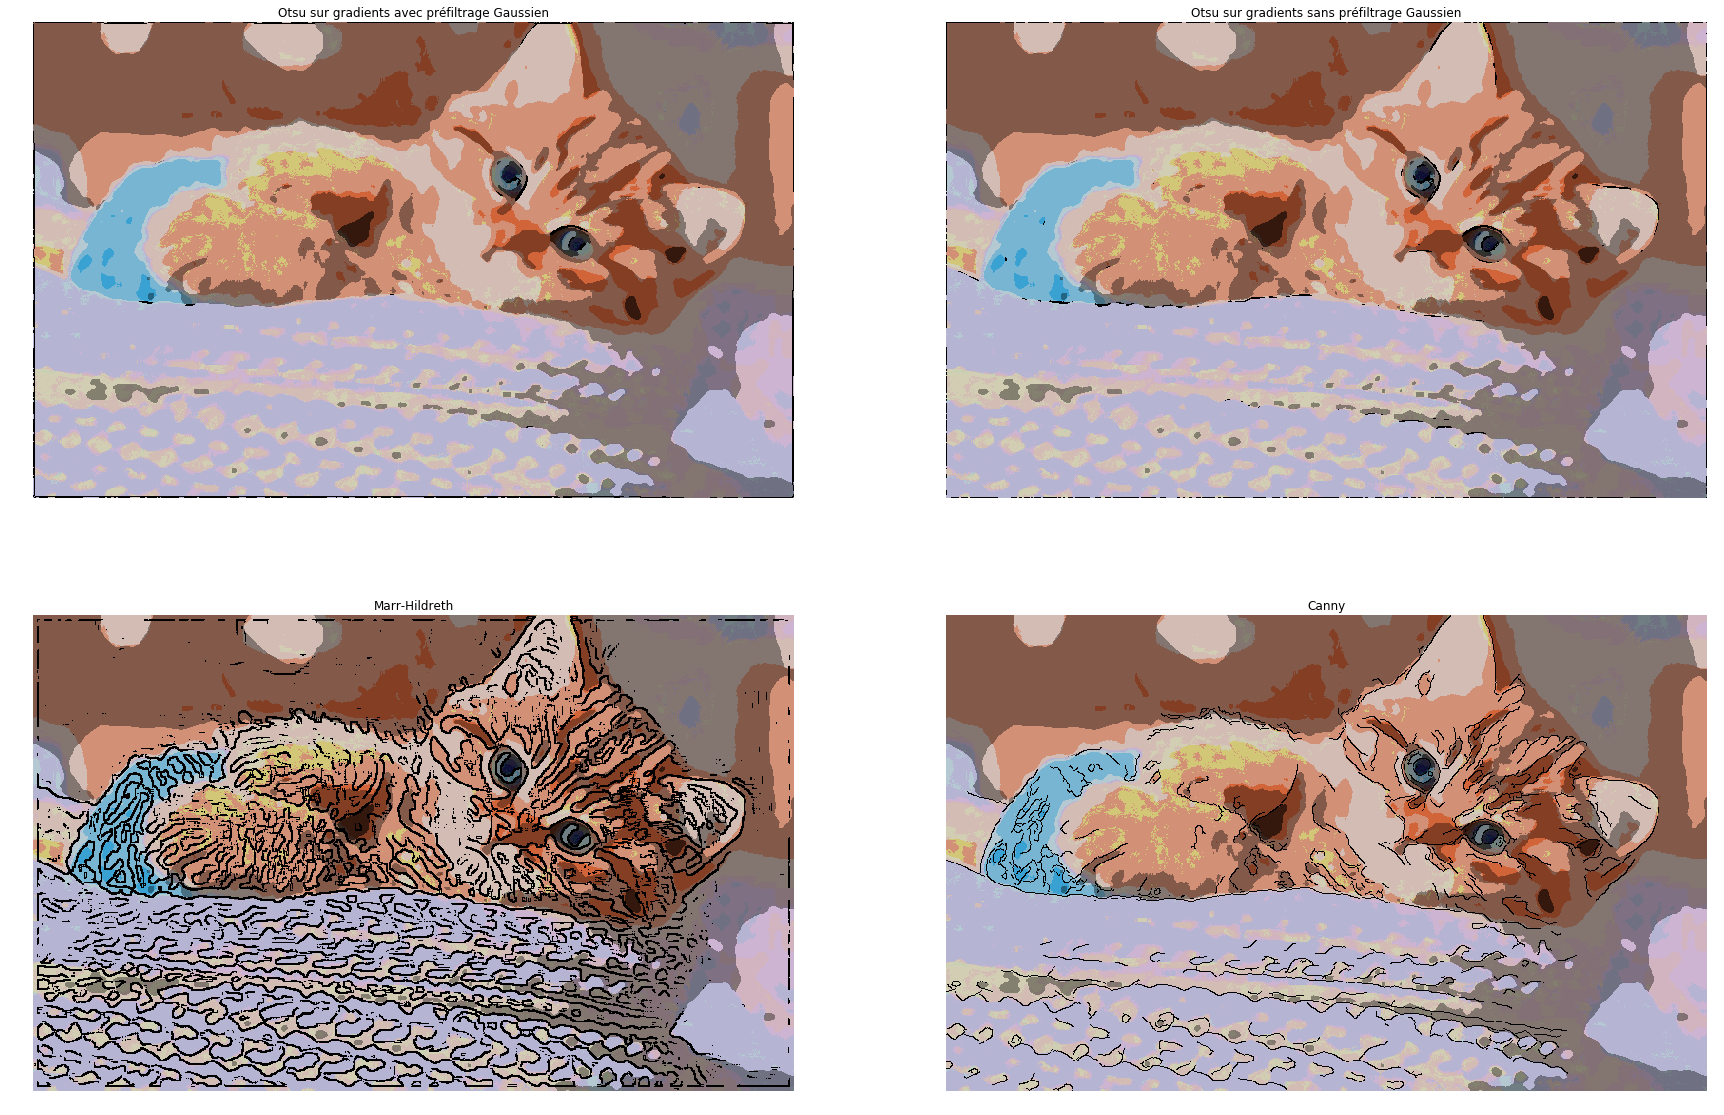

In [40]:
def add_grad_to_img(grad_img, img):
    img = img.copy()

    grad_img = grad_img.astype(np.bool_)
    
    img[grad_img] = [0, 0, 0] 
    
    return img

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(30, 20))

imshow(add_grad_to_img(seuillage_otsu(f2int(gradient_magnitude)), final_img), title="Otsu sur gradients avec préfiltrage Gaussien", ax=ax[0][0], is_bgr=True)
imshow(add_grad_to_img(seuillage_otsu(f2int(get_simple_gradients(clearness, show=False))), final_img), title="Otsu sur gradients sans préfiltrage Gaussien", ax=ax[0][1], is_bgr=True)
imshow(add_grad_to_img(apply_marr_hildreth(clearness, 0.005, 5), final_img), title="Marr-Hildreth", ax=ax[1][0], is_bgr=True)
imshow(add_grad_to_img(cv2.Canny(f2int(clearness), 100, 40), final_img), title="Canny", ax=ax[1][1], is_bgr=True)

**Réponse**: La méthode de Canny semble donner les meilleurs résultats. Les deux méthodes Otsu ne donnent pas suffisamment de contours, tandis que celle de Marr-Hildreth en donne trop, et discontinus.

## Question 19
En réalité, les traits d'un dessin sont rarement parfaitement noirs, leurs couleurs peuvent dépendre de leurs épaisseurs et de la couleur de l'objet qu'ils délimitent.

En prenant en compte ces deux considérations, proposez-une amélioration de l'effet de nos contours pour accentuer l'illusion d'un dessin. Vous pouvez combiner à votre guise différents résultats obtenus précédemment.

In [41]:
def add_coloring_grad_to_img(grad_img, img):
    img = img.copy()
    hsv_intensity = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)[:,:,2]

    grad_img = grad_img.astype(np.bool_)
    
    img[grad_img] = (255 - np.tile(hsv_intensity[grad_img].reshape(-1,1), (1,3)))
    
    return img

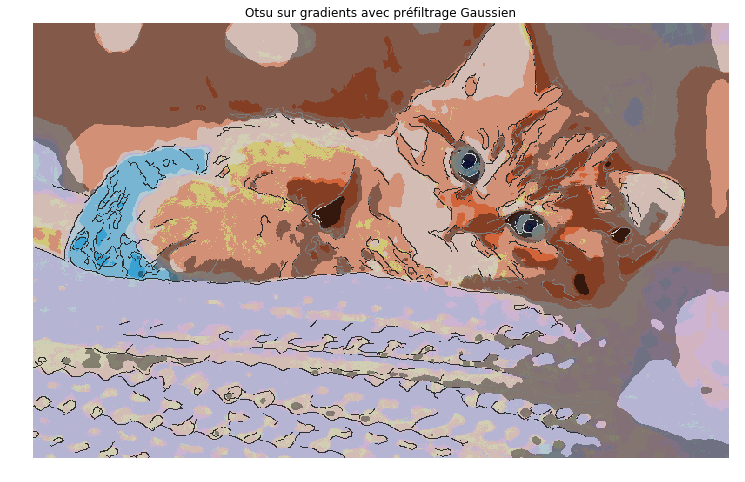

In [42]:
final_img_edge = add_coloring_grad_to_img(cv2.Canny(f2int(clearness), 100, 40), final_img)
imshow(final_img_edge, title="Otsu sur gradients avec préfiltrage Gaussien", is_bgr=True)


**Réponse**: L'amélioration proposée consiste à appliquer une couleur de contour adaptée à l'intensité du pixel de l'image originale. Pour ce faire, la couleur du contour à un pixel donné est calculé comme étant l'inverse de l'intensité, dans le modèle HSV.

# Question bonus

On vous fournit une extension de l'image précédente, à laquelle on a ajouté un dernier effet. Chargez l'image **dessin_chaton.png** et affichez-la.
Pouvez-vous identifier l'effet ajouté? Proposez une manière simple de la reproduire. 

0.98039216


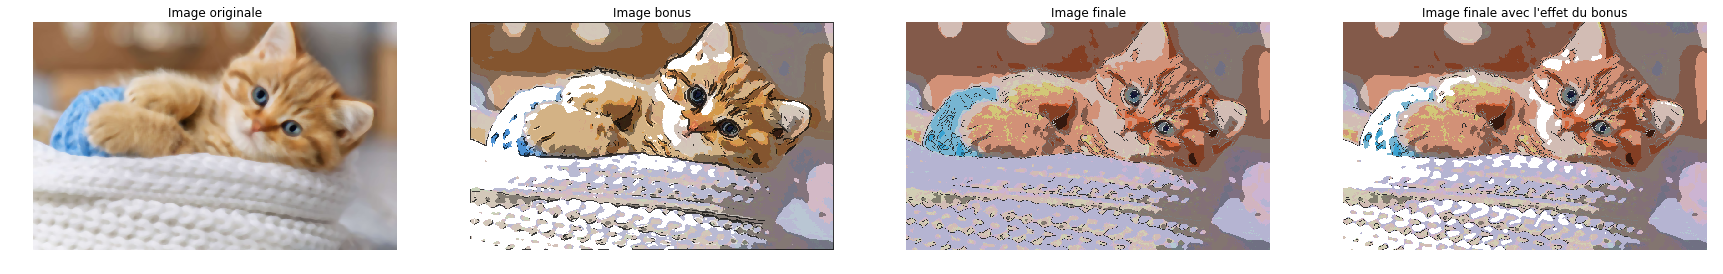

In [43]:
img_bonus = cv2.imread('data/dessin_chaton.png')

fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(30, 10))

final_img_edge_bonus = final_img_edge.copy()
final_img_edge_hsv = cv2.cvtColor(f2int(img), cv2.COLOR_BGR2HSV)
final_img_edge_hsv_intensity = int2f(final_img_edge_hsv[:, :, 2])
final_img_edge_bonus[final_img_edge_hsv_intensity > 0.88] = 255
print(np.max(final_img_edge_hsv_intensity))

final_img_bonus = cv2.cvtColor(final_img_edge_hsv, cv2.COLOR_HSV2BGR)

imshow(img, title="Image originale", is_bgr=True, ax=ax[0])
imshow(img_bonus, title="Image bonus", is_bgr=True, ax=ax[1])
imshow(final_img_edge, title="Image finale", is_bgr=True, ax=ax[2])
imshow(final_img_edge_bonus, title="Image finale avec l'effet du bonus", is_bgr=True, ax=ax[3])

**Réponse**: L'effet ajouté consiste à illuminer l'image, comme on peut voir du blanc du côté gauche du chaton.

La manière par laquelle nous avons parvenu à recréer l'effet est de trouver tous les pixels, dans l'image originale, qui dépasse un certain seuil d'intensité, du modèle HSV. Tous les pixels dont l'intensité dépasse 0.8, dans notre cas, est alors mis à 255, soit blanc.